In [1]:
import re
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoModel

In [2]:
# -----------------------------
# Định nghĩa biến device và model_name
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "vinai/phobert-base"

In [3]:
# -----------------------------
# Khai báo ánh xạ nhãn cảm xúc (Stage 2)
# -----------------------------
label_map = {"negative": 0, "neutral": 1, "positive": 2}
inv_label_map = {v: k for k, v in label_map.items()}

## Stage 1: Huấn luyện model trích xuất aspect

In [4]:
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [5]:
# Phân tách các cặp aspect và sentiment
def split_aspect(aspects):
    list_sa = []
    aspect_pairs = aspects.split('}, {')
    for pair in aspect_pairs:
        pair = pair.replace('{', '').replace('}', '')
        parts = pair.split(', ')
        if len(parts) == 2:
            aspect, sentiment = parts
            list_sa.append([aspect.strip(), sentiment.strip()])
        else:
            continue
    return list_sa

In [6]:
def list_data(file, aspect_list):
    opinions = file.split('\n\n')
    list_sa = []
    for opinion in opinions:
        if not opinion.strip():
            continue
        lines = opinion.split("\n")
        if len(lines) < 3:
            continue        
        num, sentence, aspects = lines[0], lines[1], lines[2]
        aspects = split_aspect(aspects)
        if not aspects or len(aspects) < 2:
            continue           
        list_temp = [aspect[0] for aspect in aspects]
        for aspect, sentiment in aspects:
            item = {"sentence": sentence, "aspects": list_temp}
            list_sa.append(item)
    return list_sa

In [7]:
# Đường dẫn tới file dữ liệu (Stage 1 và Stage 2 dùng chung)
data_path = "/kaggle/input/food-review/final_data.txt"
data_content = read_file(data_path)
all_aspects = ["AMBIENCE", "PRICE", "FOOD", "SERVICE", "DELIVERY"]
all_data = list_data(data_content, all_aspects)

In [8]:
# Sử dụng MultiLabelBinarizer để mã hóa các nhãn aspect (Stage 1)
tokenizer = AutoTokenizer.from_pretrained(model_name)
multi_aspect_binary = MultiLabelBinarizer(classes=all_aspects)
aspects_encoded = multi_aspect_binary.fit_transform([item["aspects"] for item in all_data])
print("Các khía cạnh:", multi_aspect_binary.classes_)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Các khía cạnh: ['AMBIENCE' 'PRICE' 'FOOD' 'SERVICE' 'DELIVERY']


In [9]:
# Định nghĩa Dataset cho Stage 1
class MultiAspectFeedbackDataset(TorchDataset):
    def __init__(self, data, labels):
        self.encodings = tokenizer([item["sentence"] for item in data],
                                   padding=True, truncation=True, max_length=128, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["aspects"] = self.labels[idx]
        return item

In [10]:
# Chia dữ liệu thành train và validation cho Stage 1
train_sentences, val_sentences, train_aspects, val_aspects = train_test_split(
    all_data, aspects_encoded, test_size=0.2, random_state=42
)
train_dataset_stage1 = MultiAspectFeedbackDataset(train_sentences, train_aspects)
val_dataset_stage1 = MultiAspectFeedbackDataset(val_sentences, val_aspects)

train_dataloader_stage1 = DataLoader(train_dataset_stage1, batch_size=16, shuffle=True)
val_dataloader_stage1 = DataLoader(val_dataset_stage1, batch_size=16, shuffle=False)

### Model PhoBERT cho multi-label classification (Stage 1)

In [11]:
class PhoBERTMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels):
        super(PhoBERTMultiLabelClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [12]:
model_stage1 = PhoBERTMultiLabelClassifier(num_labels=len(all_aspects)).to(device)
criterion_stage1 = nn.BCEWithLogitsLoss()
optimizer_stage1 = optim.AdamW(model_stage1.parameters(), lr=5e-5)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [13]:
import matplotlib.pyplot as plt

# Hàm huấn luyện Stage 1 (đã cập nhật để lưu loss theo epoch)
def train_stage1(model, train_dataloader, device="cuda", epochs=5):
    model.train()
    model.to(device)
    epoch_losses = []  # Danh sách lưu loss trung bình mỗi epoch
    for epoch in range(epochs):
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs} - Stage 1")
        progress_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}")
        for batch in progress_bar:
            optimizer_stage1.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["aspects"].to(device)
            logits = model(input_ids, attention_mask)
            loss = criterion_stage1(logits, labels)
            loss.backward()
            optimizer_stage1.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"Stage 1 - Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")
    return model, epoch_losses


In [14]:
model, losses = train_stage1(model_stage1, train_dataloader_stage1, device=device, epochs=5)



Epoch 1/5 - Stage 1


Epoch 1: 100%|██████████| 1322/1322 [04:21<00:00,  5.06it/s, loss=0.189]


Stage 1 - Epoch 1 - Avg Loss: 0.1611

Epoch 2/5 - Stage 1


Epoch 2: 100%|██████████| 1322/1322 [04:20<00:00,  5.08it/s, loss=0.144]


Stage 1 - Epoch 2 - Avg Loss: 0.0773

Epoch 3/5 - Stage 1


Epoch 3: 100%|██████████| 1322/1322 [04:20<00:00,  5.07it/s, loss=0.0266]


Stage 1 - Epoch 3 - Avg Loss: 0.0462

Epoch 4/5 - Stage 1


Epoch 4: 100%|██████████| 1322/1322 [04:20<00:00,  5.07it/s, loss=0.00604]


Stage 1 - Epoch 4 - Avg Loss: 0.0326

Epoch 5/5 - Stage 1


Epoch 5: 100%|██████████| 1322/1322 [04:20<00:00,  5.07it/s, loss=0.0065]

Stage 1 - Epoch 5 - Avg Loss: 0.0265


In [15]:
# Lưu checkpoint Stage 1
torch.save(model.state_dict(), "./absa_aspect_model.pt")

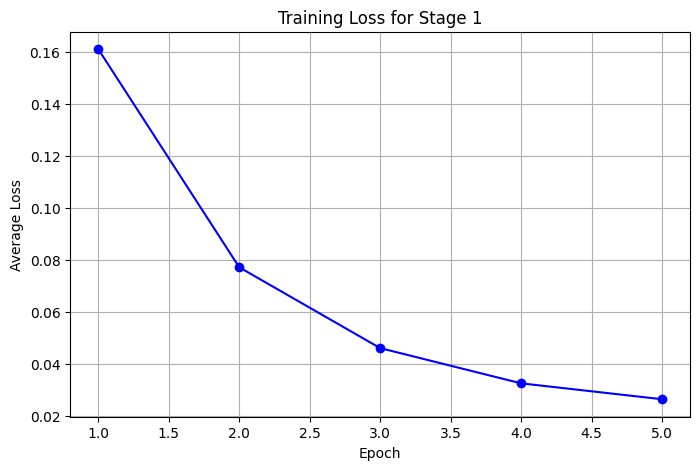

In [16]:
# Vẽ đồ thị loss theo epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses)+1), losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss for Stage 1")
plt.grid(True)
plt.show()

In [17]:
def extract_aspects_stage1(review_text, model, tokenizer, device, threshold=0.5):
    """
    Sử dụng model Stage 1 đã huấn luyện để trích xuất khía cạnh từ review.
    - Token hóa review.
    - Dự đoán các nhãn multi-label.
    - Áp dụng sigmoid và threshold để xác định nhãn kích hoạt.
    - Trích xuất tên khía cạnh (phần trước dấu gạch dưới nếu có).
    """
    inputs = tokenizer(review_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    if "token_type_ids" in inputs:
        inputs.pop("token_type_ids")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        logits = model(**inputs)
    probs = torch.sigmoid(logits)[0]
    predicted_indices = (probs > threshold).nonzero(as_tuple=True)[0].tolist()
    predicted_labels = [multi_aspect_binary.classes_[i] for i in predicted_indices]
    aspects = list(set(label.split("_")[0] for label in predicted_labels))
    return aspects


## Stage 2: Huấn luyện model phân loại cảm xúc

In [18]:
# Xử lí data
def load_and_preprocess_sentiment(file_path):
    """
    Đọc và tiền xử lý dữ liệu từ final_data.txt.
    Với mỗi cặp {aspect, sentiment}, tạo ví dụ với: "review", "aspect", "label".
    """
    examples = []
    with open(file_path, encoding="utf-8") as f:
        content = f.read().strip()
    sample_texts = re.split(r'#\d+\s*\n', content)[1:]
    for sample in sample_texts:
        lines = sample.strip().splitlines()
        if len(lines) < 2:
            continue
        review = " ".join(lines[:-1]).strip().lower()
        labels_line = lines[-1].strip()
        matches = re.findall(r"\{([^}]+)\}", labels_line)
        for match in matches:
            parts = [p.strip() for p in match.split(",")]
            if len(parts) >= 2:
                aspect = parts[0]
                sentiment = parts[1].lower()
                if sentiment in label_map:
                    examples.append({
                        "review": review,
                        "aspect": aspect,
                        "label": label_map[sentiment]
                    })
    return examples

In [19]:
sentiment_examples = load_and_preprocess_sentiment(data_path)
print(f"Stage 2: Đã tải {len(sentiment_examples)} ví dụ cho phân loại cảm xúc.")

Stage 2: Đã tải 28948 ví dụ cho phân loại cảm xúc.


In [20]:
if len(sentiment_examples) == 0:
    raise ValueError("Không có ví dụ cho Stage 2. Kiểm tra lại file dữ liệu và hàm tiền xử lý.")

In [21]:
# Chia data (cùng tỉ lệ với stage 1)
train_sentiment, val_sentiment = train_test_split(sentiment_examples, test_size=0.2, random_state=42)
print(f"Tập Stage 2 - train: {len(train_sentiment)}, val: {len(val_sentiment)}")

Tập Stage 2 - train: 23158, val: 5790


In [22]:
# Hàm tạo ground truth cho tập validation Stage 2
def build_ground_truth(val_examples):
    gt_dict = {}
    for ex in val_examples:
        review = ex["review"]
        aspect = ex["aspect"]
        sentiment_str = inv_label_map[ex["label"]]
        if review not in gt_dict:
            gt_dict[review] = {}
        gt_dict[review][aspect] = sentiment_str
    return gt_dict

In [23]:
val_gt = build_ground_truth(val_sentiment)
val_df = pd.DataFrame(list(val_gt.items()), columns=["review", "ground_truth"])
print("Tập validation ground truth (Stage 2):")
print(val_df.head())

Tập validation ground truth (Stage 2):
                                              review          ground_truth
0  lần nào đi đl mình cũng ghé đây ăn trưa thức ă...  {'FOOD': 'positive'}
1  quán này lần đầu ăn đi hơi khó tìm quàn nằm tr...  {'FOOD': 'positive'}
2  cảnh đẹp nước uống không ngon minh uống nước s...  {'FOOD': 'negative'}
3  quán lúc nào cũng đông kkk lẩu bò ngon lúc đầu...  {'FOOD': 'positive'}
4  đà lạt có rất nhiều quán phở trong đó tôi đã đ...  {'FOOD': 'positive'}


In [24]:
# Chuyển dữ liệu Stage 2 thành dataset dùng thư viện datasets
raw_dataset_stage2 = Dataset.from_dict({
    "review": [ex["review"] for ex in sentiment_examples],
    "aspect": [ex["aspect"] for ex in sentiment_examples],
    "label": [ex["label"] for ex in sentiment_examples]
})

In [25]:
# Kết hợp review và aspect thành một text duy nhất
def combine_review_aspect(example):
    example["text"] = "Review: " + example["review"] + " | Aspect: " + example["aspect"]
    return example

dataset_stage2 = raw_dataset_stage2.map(combine_review_aspect)
print(dataset_stage2)

Map:   0%|          | 0/28948 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'aspect', 'label', 'text'],
    num_rows: 28948
})


In [26]:
# Tokenize dữ liệu Stage 2
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)
tokenized_dataset_stage2 = dataset_stage2.map(tokenize_function, batched=True)
split_dataset_stage2 = tokenized_dataset_stage2.train_test_split(test_size=0.2, seed=42)
train_dataset_stage2 = split_dataset_stage2["train"]
val_dataset_stage2 = split_dataset_stage2["test"]

Map:   0%|          | 0/28948 [00:00<?, ? examples/s]

### Load model stage 2

In [27]:
# Load model Stage 2 từ base model và load trọng số encoder từ checkpoint Stage 1.
checkpoint_path = "./absa_aspect_model.pt"
model_stage2 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)
state_dict = torch.load(checkpoint_path)
new_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier")}
model_stage2.load_state_dict(new_state_dict, strict=False)
model_stage2.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-bf75a7796d1e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [28]:
# Cấu hình TrainingArguments cho Stage 2
training_args_stage2 = TrainingArguments(
    output_dir="./aspect_sentiment_model",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
def compute_metrics_stage2(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}


In [30]:
training_args_stage2 = TrainingArguments(
    output_dir="./aspect_sentiment_model",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,          # Tự động load checkpoint tốt nhất sau huấn luyện
    metric_for_best_model="accuracy",      # Sử dụng accuracy để so sánh
    greater_is_better=True,                # Accuracy càng cao càng tốt
    report_to=[]
)

trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=train_dataset_stage2,
    eval_dataset=val_dataset_stage2,
    compute_metrics=compute_metrics_stage2
)

trainer_stage2.train()
trainer_stage2.save_model("./aspect_sentiment_model")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.487200,0.492715,0.855268
2,0.356500,0.440674,0.873748
3,0.199200,0.368026,0.897927
4,0.246200,0.372716,0.900518
5,0.204700,0.401167,0.910017


In [31]:
# Sau khi trainer_stage2.train() đã chạy xong, trainer_stage2.state.log_history chứa log training.
logs = trainer_stage2.state.log_history

In [32]:
# Lấy log training loss theo từng bước
train_steps = []
train_losses = []
# Lấy log evaluation loss và evaluation accuracy tại mỗi epoch
eval_epochs = []
eval_losses = []
eval_accuracies = []

In [33]:
for log in logs:
    # Lấy log training loss
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    # Lấy log evaluation: có eval_loss và eval_accuracy cùng với epoch
    if "eval_loss" in log and "epoch" in log:
        eval_epochs.append(log["epoch"])
        eval_losses.append(log["eval_loss"])
        # Một số log có eval_accuracy, nếu không có thì bỏ qua
        if "eval_accuracy" in log:
            eval_accuracies.append(log["eval_accuracy"])

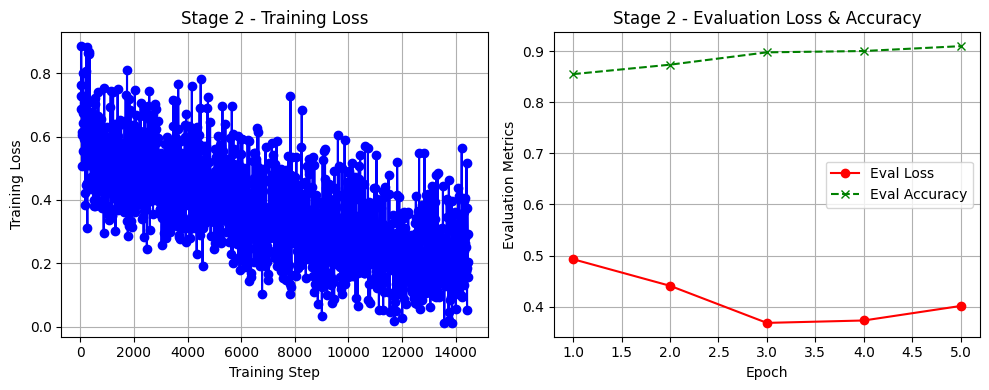

In [34]:
# Vẽ đồ thị training loss cho Stage 2 theo các bước training
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_losses, marker='o', linestyle='-', color='blue')
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Stage 2 - Training Loss")
plt.grid(True)

# Vẽ đồ thị evaluation loss theo epoch cho Stage 2
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_losses, marker='o', linestyle='-', color='red', label="Eval Loss")
if eval_accuracies:  # Nếu có dữ liệu accuracy, ta cũng vẽ
    plt.plot(eval_epochs, eval_accuracies, marker='x', linestyle='--', color='green', label="Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Evaluation Metrics")
plt.title("Stage 2 - Evaluation Loss & Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Đánh giá: 

In [35]:
data_path = "/kaggle/input/food-review/final_data.txt"  # Adjust path if necessary
file_content = read_file(data_path)

### Đánh giá riêng Stage 1

In [36]:
# Hàm xử lý dữ liệu cho Stage 1: tách review và danh sách các aspect từ nội dung file
def list_data(file_content):
    # Tách các mẫu dựa trên pattern "#số"
    sample_texts = re.split(r'#\d+\s*', file_content)[1:]
    list_sa = []
    for sample in sample_texts:
        # Tách các dòng trong mỗi mẫu
        lines = sample.strip().splitlines()
        if len(lines) < 2:
            continue        
        # Giả sử dòng đầu là review, dòng thứ 2 chứa các cặp aspect-sentiment
        review = lines[0].strip().lower()
        aspects_line = lines[1].strip()
        # Tách các cặp theo "}, {" sau khi loại bỏ dấu ngoặc nhọn
        aspect_pairs = re.split(r'},\s*{', aspects_line.strip('{}'))
        # Lấy tên aspect (trước dấu phẩy)
        aspects = [pair.split(',')[0].strip() for pair in aspect_pairs if ',' in pair]
        if aspects:
            list_sa.append({"sentence": review, "aspects": aspects})
    return list_sa

In [37]:
def evaluate_stage1(model, data, labels, batch_size=16):
    model.eval()
    all_preds = []
    all_true = []
    dataset = MultiAspectFeedbackDataset(data, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating Stage 1"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["aspects"].cpu().numpy()
            outputs = model(input_ids, attention_mask)
            # Since our model returns logits directly (a Tensor), use it.
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(probs)
            all_true.append(true_labels)
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    threshold = 0.5
    preds_binary = (all_preds > threshold).astype(int)
    f1 = f1_score(all_true, preds_binary, average="micro")
    acc = accuracy_score(all_true, preds_binary)
    precision = precision_score(all_true, preds_binary, average="micro", zero_division=0)
    recall = recall_score(all_true, preds_binary, average="micro", zero_division=0)
    print(f"Stage 1 - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    model.train()

print("\nĐánh giá riêng mô hình Stage 1 trên tập validation:")
evaluate_stage1(model_stage1_demo, val_data_stage1, val_labels_stage1)



Đánh giá riêng mô hình Stage 1 trên tập validation:


NameError: name 'model_stage1_demo' is not defined

In [ ]:
# Stage 1: List data with reviews and aspect names
all_data_stage1 = list_data(file_content)

In [ ]:
all_aspects = ["AMBIENCE", "PRICE", "FOOD", "SERVICE", "DELIVERY"]
multi_aspect_binary = MultiLabelBinarizer(classes=all_aspects)
aspects_encoded = multi_aspect_binary.fit_transform([item["aspects"] for item in all_data_stage1])
print("Các khía cạnh (Stage 1):", multi_aspect_binary.classes_)

In [ ]:
# -----------------------------
# Dataset cho Stage 1
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(model_name)

class MultiAspectFeedbackDataset(TorchDataset):
    def __init__(self, data, labels):
        self.encodings = tokenizer([item["sentence"] for item in data],
                                   padding=True, truncation=True, max_length=128, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.float)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["aspects"] = self.labels[idx]
        return item


In [ ]:
# To maintain order, compute labels over all Stage 1 data and then select those corresponding to train and validation.
all_labels = multi_aspect_binary.transform([item["aspects"] for item in all_data_stage1])
train_labels_stage1 = [all_labels[i] for i, item in enumerate(all_data_stage1) if item in train_data_stage1]
val_labels_stage1 = [all_labels[i] for i, item in enumerate(all_data_stage1) if item in val_data_stage1]

train_dataset_stage1 = MultiAspectFeedbackDataset(train_data_stage1, train_labels_stage1)
val_dataset_stage1 = MultiAspectFeedbackDataset(val_data_stage1, val_labels_stage1)

train_dataloader_stage1 = DataLoader(train_dataset_stage1, batch_size=16, shuffle=True)
val_dataloader_stage1 = DataLoader(val_dataset_stage1, batch_size=16, shuffle=False)

In [ ]:
# -----------------------------
# Model for Stage 1: PhoBERTMultiLabelClassifier
# -----------------------------
class PhoBERTMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels):
        super(PhoBERTMultiLabelClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# -----------------------------
# Load Stage 1 checkpoint (do not retrain if already trained)
# -----------------------------
model_stage1_demo = PhoBERTMultiLabelClassifier(num_labels=len(all_aspects)).to(device)
checkpoint_stage1 = "./absa_aspect_model.pt"  # Adjust checkpoint path if needed
model_stage1_demo.load_state_dict(torch.load(checkpoint_stage1), strict=False)
model_stage1_demo.to(device)
print("Model Stage 1 đã được load từ checkpoint.")


In [ ]:
def extract_aspects_stage1(review_text, model, tokenizer, device, threshold=0.5):
    inputs = tokenizer(review_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    inputs.pop("token_type_ids", None)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        logits = model(**inputs)
    probs = torch.sigmoid(logits)[0]
    predicted_indices = (probs > threshold).nonzero(as_tuple=True)[0].tolist()
    predicted_labels = [multi_aspect_binary.classes_[i] for i in predicted_indices]
    aspects = list(set(label.split("_")[0] for label in predicted_labels))
    return aspects

In [ ]:
def evaluate_stage1(model, data, labels, batch_size=16):
    model.eval()
    all_preds = []
    all_true = []
    dataset = MultiAspectFeedbackDataset(data, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating Stage 1"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["aspects"].cpu().numpy()
            outputs = model(input_ids, attention_mask)
            # Since our model returns logits directly (a Tensor), use it.
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(probs)
            all_true.append(true_labels)
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    threshold = 0.5
    preds_binary = (all_preds > threshold).astype(int)
    f1 = f1_score(all_true, preds_binary, average="micro")
    acc = accuracy_score(all_true, preds_binary)
    precision = precision_score(all_true, preds_binary, average="micro", zero_division=0)
    recall = recall_score(all_true, preds_binary, average="micro", zero_division=0)
    print(f"Stage 1 - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    model.train()


In [ ]:
print("\nĐánh giá riêng mô hình Stage 1 trên tập validation:")
evaluate_stage1(model_stage1_demo, val_data_stage1, val_labels_stage1)

### Đánh giá tổng thể cả hai Stage

In [ ]:
# For Stage 2: Create one example per {aspect, sentiment} pair.
def load_and_preprocess_sentiment(file_path):
    examples = []
    content = read_file(file_path)
    sample_texts = re.split(r'#\d+\s*', content)[1:]
    for sample in sample_texts:
        lines = sample.strip().splitlines()
        if len(lines) < 2:
            continue
        # Use the same review as Stage 1 (line 1)
        review = lines[0].strip().lower()
        aspects_line = lines[1].strip()
        matches = re.findall(r"\{([^}]+)\}", aspects_line)
        for match in matches:
            parts = [p.strip() for p in match.split(",")]
            if len(parts) >= 2:
                aspect = parts[0]
                sentiment = parts[1].lower()
                if sentiment in label_map:
                    examples.append({
                        "review": review,
                        "aspect": aspect,
                        "label": label_map[sentiment]
                    })
    return examples

In [ ]:
# Stage 2: Create examples for each aspect-sentiment pair
all_data_stage2 = load_and_preprocess_sentiment(data_path)
print(f"Stage 2: Đã tải {len(all_sentiment_examples)} ví dụ cho phân loại cảm xúc.")

In [ ]:
# For Stage 2, keep only examples whose review is in the common validation set.
val_data_stage2 = [ex for ex in all_data_stage2 if ex["review"] in val_reviews]
train_data_stage2 = [ex for ex in all_data_stage2 if ex["review"] not in val_reviews]
print(f"Tập Stage 2 - train: {len(train_data_stage2)}, validation: {len(val_data_stage2)}")

In [ ]:
def build_ground_truth(val_examples):
    gt_dict = {}
    for ex in val_examples:
        review = ex["review"]
        aspect = ex["aspect"]
        sentiment_str = inv_label_map[ex["label"]]
        if review not in gt_dict:
            gt_dict[review] = {}
        gt_dict[review][aspect] = sentiment_str
    return gt_dict

val_gt = build_ground_truth(val_data_stage2)
val_df = pd.DataFrame(list(val_gt.items()), columns=["review", "ground_truth"])
print("Tập validation ground truth (Stage 2):")
print(val_df.head())

In [ ]:
# For Stage 2 training (if needed), create a Hugging Face Dataset from all Stage 2 examples.
raw_dataset_stage2 = Dataset.from_dict({
    "review": [ex["review"] for ex in all_sentiment_examples],
    "aspect": [ex["aspect"] for ex in all_sentiment_examples],
    "label": [ex["label"] for ex in all_sentiment_examples]
})

In [ ]:
def combine_review_aspect(example):
    example["text"] = "Review: " + example["review"] + " | Aspect: " + example["aspect"]
    return example

dataset_stage2 = raw_dataset_stage2.map(combine_review_aspect)
print(dataset_stage2)

In [ ]:
# Tokenize Stage 2 data
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)
tokenized_dataset_stage2 = dataset_stage2.map(tokenize_function, batched=True)
# We do not re-split here for evaluation; we already have val_data_stage2.
print("Tập Stage 2 - train (if needed):", len([ex for ex in all_sentiment_examples if ex["review"] not in val_reviews]))
print("Tập Stage 2 - validation (common):", len(val_data_stage2))

In [ ]:
# -----------------------------
# Load Stage 2 checkpoint from directory
# -----------------------------
import os
import re

# Đường dẫn chứa các checkpoint của Stage 2
checkpoint_parent_dir = "/kaggle/input/checkpoint/aspect_sentiment_model/"

# Ưu tiên load checkpoint từ thư mục 'best_model' nếu có
best_model_dir = os.path.join(checkpoint_parent_dir, "best_model")
if os.path.exists(best_model_dir):
    checkpoint_dir = best_model_dir
else:
    # Nếu không có thư mục 'best_model', chọn checkpoint có số thứ tự lớn nhất
    checkpoints = [d for d in os.listdir(checkpoint_parent_dir) if re.match(r"checkpoint-\d+", d)]
    if checkpoints:
         # Sắp xếp theo số thứ tự (convert số trong tên checkpoint)
         checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))
         checkpoint_dir = os.path.join(checkpoint_parent_dir, checkpoints[-1])
    else:
         raise ValueError("Không tìm thấy checkpoint nào trong thư mục: " + checkpoint_parent_dir)

print("Loading Stage 2 model from checkpoint directory:", checkpoint_dir)
model_stage2 = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_dir,
    num_labels=3,
    problem_type="single_label_classification"
).to(device)


In [ ]:
def demo_full_pipeline(review_text, model_stage1, model_stage2, tokenizer, device, threshold=0.5):
    aspects = extract_aspects_stage1(review_text, model_stage1, tokenizer, device, threshold)
    if not aspects:
        return {}
    sentiments = {}
    for aspect in aspects:
        sentiment = predict_sentiment_stage2(review_text, aspect, model_stage2, tokenizer, device)
        sentiments[aspect] = sentiment
    return sentiments

In [ ]:
def predict_sentiment_stage2(review_text, aspect, model_stage2, tokenizer, device):
    input_text = "Review: " + review_text.lower() + " | Aspect: " + aspect
    inputs = tokenizer(input_text, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
    inputs.pop("token_type_ids", None)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model_stage2.eval()
    with torch.no_grad():
        outputs = model_stage2(**inputs)
    pred = outputs.logits.argmax(dim=-1).item()
    return inv_label_map[pred]

In [ ]:
def build_ground_truth(val_examples):
    gt_dict = {}
    for ex in val_examples:
        review = ex["review"]
        aspect = ex["aspect"]
        sentiment_str = inv_label_map[ex["label"]]
        if review not in gt_dict:
            gt_dict[review] = {}
        gt_dict[review][aspect] = sentiment_str
    return gt_dict

val_gt = build_ground_truth(val_data_stage2)
val_df = pd.DataFrame(list(val_gt.items()), columns=["review", "ground_truth"])
print("Tập validation ground truth (Stage 2):")
print(val_df.head())

pred_list = []
for review in val_df["review"]:
    pred = demo_full_pipeline(review, model_stage1_demo, model_stage2, tokenizer, device, threshold=0.5)
    pred_list.append({"review": review, "predicted": pred})
pred_df = pd.DataFrame(pred_list)
print("Tập dự đoán của pipeline:")
print(pred_df.head())

In [ ]:
matches = 0
total = len(val_df)
for idx in range(total):
    gt = val_df.loc[idx, "ground_truth"]
    pred = pred_df.loc[idx, "predicted"]
    if gt == pred:
        matches += 1
if total > 0:
    combined_accuracy = matches / total
    print(f"Accuracy kết hợp trên tập validation: {combined_accuracy:.4f}")
    print(f"Số review trong tập validation: {total}, Số review dự đoán đúng: {matches}")
else:
    print("Không có review nào trong tập validation Stage 2.")

### Review mẫu

In [ ]:
# Demo pipeline for a sample review
sample_review = "Khẩu vị vừa ăn hợp vệ sinh, không gian quán rộng view cũng tạm được. Đặc biệt là phục vụ rất nhiệt tình và vui vẻ."
demo_result = demo_full_pipeline(sample_review, model_stage1_demo, model_stage2, tokenizer, device, threshold=0.5)
print("Demo pipeline ABSA cho review mẫu:")
print("Review:", sample_review)
print("Kết quả dự đoán:", demo_result)

In [ ]:
Nghe phông phanh về trà sữa có viên phô mai to ú ù lâu rồi mà chưa có dịp đi thử. Thế là hôm qua cũng rảnh rỗi nên rủ tụi ‘cạ cứng’ đi uống thử. Đoán là viên phô mai chắc cũng to to, ai dè to thật, ăn một phát mà muốn ghiền luôn!  1st Tea 1st Tea trang trí chủ đạo là 3 tông màu trắng-xanh-vàng rất dễ thương Hình vẽ hoạt hình vui nhộn  … và dành hẳn cho bạn một góc chụp hình check-in   Menu quán khá đa dạng, phong phú, có các loại nước như: trà, trà sữa, macchiato, đá xay,… mà giá thì chỉ dao động từ 21K – 44K thôi. Tùy size, tùy loại nước uống mà bạn sẽ nhận được ly khác nhau, nhưng mà size nào thì ly cũng to cả Trà sữa phô mai ú ù – size M: 36K Mình thì mình ưng phô mai nên mình oder một ly trà sữa trân châu có viên phô mai bự-chà-bá. Thạch trân chân hoàng kim dai dai thơm thơm, trà sữa rất vừa uống. Matcha Macchiato – size M: 34K Việt quất phô mai đá xay – size S: 37K Nói là size S vậy thôi chứ ‘quất’ 1 ly thôi là no-cành-hông rồi đó. Nhóm tụi mình uống 4 ly mà chỉ có 143K thôi. Nhìn chung, so với mặt bằng chung trên thị trường trà sữa hiện nay thì giá như thế này là hợp lý lắm luôn! Mình với tụi bạn kết quán này lắm, cuối tuần tụ tập hoặc tấp vào trốn nắng một xíu thôi cũng thấy thoải mái rồi. Nhất định, mình sẽ ghé 1st Tea lần nữa, có ai đi với mình không ta?


In [ ]:
# Demo pipeline for a sample review
sample_review = "Nghe phông phanh về trà sữa có viên phô mai to ú ù lâu rồi mà chưa có dịp đi thử. Thế là hôm qua cũng rảnh rỗi nên rủ tụi ‘cạ cứng’ đi uống thử. Đoán là viên phô mai chắc cũng to to, ai dè to thật, ăn một phát mà muốn ghiền luôn!  1st Tea 1st Tea trang trí chủ đạo là 3 tông màu trắng-xanh-vàng rất dễ thương Hình vẽ hoạt hình vui nhộn  … và dành hẳn cho bạn một góc chụp hình check-in mà giá thì chỉ dao động từ 21K – 44K thôi"
"
demo_result = demo_full_pipeline(sample_review, model_stage1_demo, model_stage2, tokenizer, device, threshold=0.5)
print("Demo pipeline ABSA cho review mẫu:")
print("Review:", sample_review)
print("Kết quả dự đoán:", demo_result)

### More metrics 

In [ ]:
total = len(val_df)
matches = 0

# Lists for per-review metrics
jaccard_list = []
per_review_precisions = []
per_review_recalls = []
per_review_f1s = []

# Counters for micro metrics (aggregated over all reviews)
TP_total = 0
FP_total = 0
FN_total = 0

for idx in range(total):
    gt = val_df.loc[idx, "ground_truth"]
    pred = pred_df.loc[idx, "predicted"]
    if gt == pred:
        matches += 1

    # Convert each review's ground truth and prediction dictionaries to sets of (aspect, sentiment) tuples.
    gt_set = set(gt.items())
    pred_set = set(pred.items())

    # Compute Jaccard Index for this review.
    union = gt_set.union(pred_set)
    if len(union) > 0:
        jaccard = len(gt_set.intersection(pred_set)) / len(union)
    else:
        jaccard = 1.0
    jaccard_list.append(jaccard)

    # Compute true positives (TP), false positives (FP), and false negatives (FN) for this review.
    TP = len(gt_set.intersection(pred_set))
    FP = len(pred_set - gt_set)
    FN = len(gt_set - pred_set)
    TP_total += TP
    FP_total += FP
    FN_total += FN

    # Per-review precision, recall, and F1.
    if len(pred_set) > 0:
        precision_i = TP / len(pred_set)
    else:
        precision_i = 1.0 if len(gt_set) == 0 else 0.0
    if len(gt_set) > 0:
        recall_i = TP / len(gt_set)
    else:
        recall_i = 1.0 if len(pred_set) == 0 else 0.0
    if precision_i + recall_i > 0:
        f1_i = 2 * precision_i * recall_i / (precision_i + recall_i)
    else:
        f1_i = 0.0

    per_review_precisions.append(precision_i)
    per_review_recalls.append(recall_i)
    per_review_f1s.append(f1_i)

# Combined accuracy at the review level.
combined_accuracy = matches / total if total > 0 else 0
# Average Jaccard Index across reviews.
avg_jaccard = sum(jaccard_list) / total if total > 0 else 0
# Macro metrics (averaged over reviews).
macro_precision = sum(per_review_precisions) / total if total > 0 else 0
macro_recall = sum(per_review_recalls) / total if total > 0 else 0
macro_f1 = sum(per_review_f1s) / total if total > 0 else 0

# Global micro metrics (aggregated over all review examples).
if (TP_total + FP_total) > 0:
    micro_precision = TP_total / (TP_total + FP_total)
else:
    micro_precision = 0
if (TP_total + FN_total) > 0:
    micro_recall = TP_total / (TP_total + FN_total)
else:
    micro_recall = 0
if micro_precision + micro_recall > 0:
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
else:
    micro_f1 = 0

print(f"Accuracy kết hợp trên tập validation: {combined_accuracy:.4f}")
print(f"Số review trong tập validation: {total}, Số review dự đoán đúng: {matches}")
print(f"Average Jaccard Index: {avg_jaccard:.4f}")

print("\nPer-review (macro) metrics (averaged over reviews):")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

print("\nGlobal (micro) metrics (aggregated over all review aspects):")
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall: {micro_recall:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")
